In [1]:
spark

spark.stop()

spark = SparkSession \
    .builder \
    .appName("Funnel") \
    .master("yarn") \
    .config("spark.total.executor.cores","12")\
    .config("spark.executor.memory","1G")\
    .getOrCreate();

In [2]:
header_text = "source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue"

In [3]:
from pyspark.sql.types import *

In [4]:
attr_list = []

In [5]:
for each_attr in header_text.split(','):
    attr_list.append(StructField(each_attr, StringType(), True))


In [6]:
custom_schema = StructType(attr_list)

In [7]:
custom_schema

StructType(List(StructField(source,StringType,true),StructField(isTrueDirect,StringType,true),StructField(sourceKeyword,StringType,true),StructField(medium,StringType,true),StructField(isVideoAd,StringType,true),StructField(fullVisitorId,StringType,true),StructField(visitId,StringType,true),StructField(date,StringType,true),StructField(newVisits,StringType,true),StructField(hitReferer,StringType,true),StructField(hitType,StringType,true),StructField(hitAction_type,StringType,true),StructField(hitNumber,StringType,true),StructField(hitHour,StringType,true),StructField(hitMin,StringType,true),StructField(timeMicroSec,StringType,true),StructField(v2ProductName,StringType,true),StructField(productListName,StringType,true),StructField(isClick,StringType,true),StructField(isImpression,StringType,true),StructField(sessionQualityDim,StringType,true),StructField(timeOnScreen,StringType,true),StructField(timeOnSite,StringType,true),StructField(totalTransactionRevenue,StringType,true)))

In [8]:
raw_df = spark.read.format('csv').schema(custom_schema).option('header','true').option('mode','DROPMALFORMED')\
.load('/root/funnel/*')

In [9]:
! ls -ls /root/funnel

total 1659324
133772 -rw-r--r-- 1 root root 136974517 Nov 27 11:30 000000000000
163700 -rw-r--r-- 1 root root 167622584 Nov 27 11:30 000000000001
148560 -rw-r--r-- 1 root root 152118014 Nov 27 11:30 000000000002
164844 -rw-r--r-- 1 root root 168793956 Nov 27 11:30 000000000003
154620 -rw-r--r-- 1 root root 158326709 Nov 27 11:30 000000000004
199532 -rw-r--r-- 1 root root 204312912 Nov 27 11:30 000000000005
172656 -rw-r--r-- 1 root root 176794215 Nov 27 11:30 000000000006
195344 -rw-r--r-- 1 root root 200026989 Nov 27 11:30 000000000007
155880 -rw-r--r-- 1 root root 159615699 Nov 27 11:31 000000000008
170416 -rw-r--r-- 1 root root 174500181 Nov 27 11:31 000000000009


In [10]:
! cat /root/funnel/* | wc -l

11375061


In [11]:
! head -3 /root/funnel/000000000000

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [12]:
mem_raw_df = raw_df.repartition(60).cache()

### Numbers of Rows

mem_raw_df.count()

mem_raw_df.columns

In [13]:
allCol_list = mem_raw_df.columns

In [14]:
removeCol_list = ['timeOnScreen']

In [15]:
for i in removeCol_list:
    allCol_list.remove(i)

In [16]:
newCol_list = []

In [17]:
newCol_list = allCol_list

In [18]:
filtered_raw_df = mem_raw_df.select(newCol_list)

# 2. Data Preparation

## Data Cleansing

In [19]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

### Remove Null

In [20]:
def f_removenull(origin):
    if origin == None:
        return 'NULL'
    else:
        return origin

In [21]:
removenull = udf(lambda x: f_removenull(x),StringType())

### Make Binary

In [22]:
def f_makebinary(origin):
    if origin == None:
        return 'FALSE'
    elif origin == 'true':
        return 'TRUE'
    elif origin == '1':
        return 'TRUE'
    else:
        return 'NULL'

In [23]:
makebinary = udf(lambda x: f_makebinary(x),StringType())

### Clean Null with Zero

In [24]:
def f_cleanNullwithZero(item):
    if item == None:
        new = '0'
        return new
    else:
        return item

In [25]:
cleanNullwithZero = udf(lambda x:f_cleanNullwithZero(x),StringType())

### Make Dollar

In [26]:
def f_makedollar(revenue):
    if revenue == None:
        return 0
    else:
        return revenue/1000000

In [27]:
makedollar = udf(lambda x: f_makedollar(x),FloatType())

In [28]:
from pyspark.sql.functions import col

In [29]:
crunched_df = filtered_raw_df.\
withColumn('hitHour',col('hitHour').cast(FloatType())).\
withColumn('hitMin',col('hitMin').cast(FloatType())).\
withColumn('hitNumber',col('hitNumber').cast(FloatType())).\
withColumn('timeMicroSec',col('timeMicroSec').cast(FloatType())).\
withColumn('timeOnSite',col('timeOnSite').cast(FloatType())).\
withColumn('totalTransactionRevenue',cleanNullwithZero(col('totalTransactionRevenue')).cast(FloatType())).\
withColumn('newVisits',makebinary(col('newVisits'))).\
withColumn('sourceKeyword',removenull(col('sourceKeyword'))).\
withColumn('isVideoAd',makebinary(col('isVideoAd'))).\
withColumn('hitReferer',removenull(col('hitReferer'))).\
withColumn('isClick',makebinary(col('isClick'))).\
withColumn('isImpression',makebinary(col('isImpression'))).\
withColumn('sessionQualityDim',removenull(col('sessionQualityDim'))).\
withColumn('timeOnSite',removenull(col('timeOnSite'))).\
withColumn('totalTransactionRevenue',makedollar(col('totalTransactionRevenue'))).\
withColumn('isTrueDirect',makebinary(col('isTrueDirect')))

### Data Enhancement: Summary within Partition

In [30]:
from pyspark.sql.functions import col, udf, sum
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.window import Window

In [31]:
crunched_df

DataFrame[source: string, isTrueDirect: string, sourceKeyword: string, medium: string, isVideoAd: string, fullVisitorId: string, visitId: string, date: string, newVisits: string, hitReferer: string, hitType: string, hitAction_type: string, hitNumber: float, hitHour: float, hitMin: float, timeMicroSec: float, v2ProductName: string, productListName: string, isClick: string, isImpression: string, sessionQualityDim: string, timeOnSite: string, totalTransactionRevenue: float]

crunched_df.columns

In [32]:
import sys

In [33]:
from pyspark.sql.types import *

In [34]:
from pyspark.sql.functions import *

In [35]:
w = Window()\
   .partitionBy('fullVisitorId','visitId')\
   .orderBy(col("hitNumber").cast("long"))

In [36]:
windowSpec = Window\
.partitionBy('fullVisitorId','visitId')\
.orderBy(col("hitNumber").cast("long"))\
.rangeBetween(-sys.maxsize, sys.maxsize)

In [37]:
from pyspark.sql import functions as func

In [38]:
Diff_hitNumber = func.max(col('hitNumber').cast(IntegerType())).over(windowSpec) - func.min(col('hitNumber').cast(IntegerType())).over(windowSpec)

In [39]:
Diff_timeMicroSec = func.max(col('timeMicroSec').cast(IntegerType())).over(windowSpec) - func.min(col('timeMicroSec').cast(IntegerType())).over(windowSpec)

In [40]:
Diff_hitHour = func.max(col('hitHour').cast(IntegerType())).over(windowSpec) - func.min(col('hitHour').cast(IntegerType())).over(windowSpec)

In [41]:
Diff_hitMin = func.max(col('hitMin').cast(IntegerType())).over(windowSpec) - func.min(col('hitMin').cast(IntegerType())).over(windowSpec)

In [42]:
first_hitNumber = func.first(col('hitNumber').cast(IntegerType())).over(windowSpec)

In [43]:
last_hitNumber = func.last(col('hitNumber').cast(IntegerType())).over(windowSpec)

In [44]:
first_Action_type = func.first(col('hitAction_type').cast(StringType())).over(windowSpec)

In [45]:
last_Action_type = func.last(col('hitAction_type').cast(StringType())).over(windowSpec)

In [46]:
from pyspark.sql.functions import to_timestamp

In [47]:
####Rev01

In [48]:
partitionCal_df = crunched_df\
.withColumn('first_hitNumber', first_hitNumber)\
.withColumn('last_hitNumber', last_hitNumber)\
.withColumn('Diff_hitNumber', Diff_hitNumber)\
.withColumn('Diff_timeMicroSec', Diff_timeMicroSec)\
.withColumn('Diff_hitHour', Diff_hitHour)\
.withColumn('Diff_hitMin', Diff_hitMin)\
.withColumn('first_Action_type', first_Action_type)\
.withColumn('last_Action_type', last_Action_type)\
.withColumn('last_Action_type',col('last_Action_type').cast(FloatType()))\
.dropna()

In [49]:
partitionCal_df.columns

['source',
 'isTrueDirect',
 'sourceKeyword',
 'medium',
 'isVideoAd',
 'fullVisitorId',
 'visitId',
 'date',
 'newVisits',
 'hitReferer',
 'hitType',
 'hitAction_type',
 'hitNumber',
 'hitHour',
 'hitMin',
 'timeMicroSec',
 'v2ProductName',
 'productListName',
 'isClick',
 'isImpression',
 'sessionQualityDim',
 'timeOnSite',
 'totalTransactionRevenue',
 'first_hitNumber',
 'last_hitNumber',
 'Diff_hitNumber',
 'Diff_timeMicroSec',
 'Diff_hitHour',
 'Diff_hitMin',
 'first_Action_type',
 'last_Action_type']

In [50]:
def f_removeLastItem(list):
    list.pop()
    return list

In [51]:
removeLastItem = func.udf(lambda x:removeLastItem(x))

In [52]:
collectList_df = partitionCal_df.groupBy([
'source',
 ##'isTrueDirect',
 ##'sourceKeyword',
 ##'medium',
 'isVideoAd',
 'fullVisitorId',
 'visitId',
 #'date',
 ##'newVisits',
 ##'hitReferer',
 #'hitType',
 #'hitAction_type',
 #'hitNumber',
 #'hitHour',
 #'hitMin',
 #'timeMicroSec',
 #'v2ProductName',
 #'productListName',
 #'isClick',
 #'isImpression',
 ##'sessionQualityDim',
 #'timeOnSite',
 #'totalTransactionRevenue',
 'first_hitNumber',
 'last_hitNumber',
 'Diff_hitNumber',
 'Diff_timeMicroSec',
 'Diff_hitHour',
 'Diff_hitMin',
 'first_Action_type',
 'last_Action_type']).agg(func.collect_list('hitAction_type'))\
#.withColumn('collect_list(hitAction_type)',removeLastItem(col('collect_list(hitAction_type)')))

##### The action type. Click through of product lists = 1, Product detail views = 2, Add product(s) to cart = 3, Remove product(s) from cart = 4, Check out = 5, Completed purchase = 6, Refund of purchase = 7, Checkout options = 8, Unknown = 0.

### Feature Selection

In [53]:
funnel_col_list = collectList_df.columns

In [54]:
funnel_col_list

['source',
 'isVideoAd',
 'fullVisitorId',
 'visitId',
 'first_hitNumber',
 'last_hitNumber',
 'Diff_hitNumber',
 'Diff_timeMicroSec',
 'Diff_hitHour',
 'Diff_hitMin',
 'first_Action_type',
 'last_Action_type',
 'collect_list(hitAction_type)']

In [55]:
raw_funnel_df = collectList_df.select(['fullVisitorId',
 'visitId',
 'first_hitNumber',
 'last_hitNumber',
 'Diff_hitNumber',
 'Diff_hitHour',
 'Diff_hitMin',
 'Diff_timeMicroSec',
 'first_Action_type',
 'last_Action_type',
 'collect_list(hitAction_type)'])

### Declare Functions for Removing Duplication and Last items in List

In [56]:
def f_removedupINLIST(l):
    seen = set()
    new_list = [x for x in l if not (x in seen or seen.add(x))]
    new_list.pop()
    return new_list

In [57]:
removedupINLIST = func.udf(lambda x: f_removedupINLIST(x))

In [58]:
raw_funnel_df.columns

['fullVisitorId',
 'visitId',
 'first_hitNumber',
 'last_hitNumber',
 'Diff_hitNumber',
 'Diff_hitHour',
 'Diff_hitMin',
 'Diff_timeMicroSec',
 'first_Action_type',
 'last_Action_type',
 'collect_list(hitAction_type)']

In [59]:
f_length_list = func.udf(lambda x: len(x),IntegerType())

In [60]:
seq_funnel_df = raw_funnel_df.withColumn('seq_hitAction_type',removedupINLIST(col('collect_list(hitAction_type)')))\
.withColumn('length_hitAction_type',f_length_list(col('collect_list(hitAction_type)')))

In [61]:
seq_funnel_df.columns

['fullVisitorId',
 'visitId',
 'first_hitNumber',
 'last_hitNumber',
 'Diff_hitNumber',
 'Diff_hitHour',
 'Diff_hitMin',
 'Diff_timeMicroSec',
 'first_Action_type',
 'last_Action_type',
 'collect_list(hitAction_type)',
 'seq_hitAction_type',
 'length_hitAction_type']

In [62]:
seq_funnel_df

DataFrame[fullVisitorId: string, visitId: string, first_hitNumber: int, last_hitNumber: int, Diff_hitNumber: int, Diff_hitHour: int, Diff_hitMin: int, Diff_timeMicroSec: int, first_Action_type: string, last_Action_type: float, collect_list(hitAction_type): array<string>, seq_hitAction_type: string, length_hitAction_type: int]

seq_funnel_df.groupBy('length_hitAction_type','last_Action_type').count()\
.orderBy(col('last_Action_type').desc(),col('length_hitAction_type').asc()).show()

##### The action type. Click through of product lists = 1, Product detail views = 2, Add product(s) to cart = 3, Remove product(s) from cart = 4, Check out = 5, Completed purchase = 6, Refund of purchase = 7, Checkout options = 8, Unknown = 0.

In [63]:
seq_funnel_df.printSchema()

root
 |-- fullVisitorId: string (nullable = true)
 |-- visitId: string (nullable = true)
 |-- first_hitNumber: integer (nullable = true)
 |-- last_hitNumber: integer (nullable = true)
 |-- Diff_hitNumber: integer (nullable = true)
 |-- Diff_hitHour: integer (nullable = true)
 |-- Diff_hitMin: integer (nullable = true)
 |-- Diff_timeMicroSec: integer (nullable = true)
 |-- first_Action_type: string (nullable = true)
 |-- last_Action_type: float (nullable = true)
 |-- collect_list(hitAction_type): array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- seq_hitAction_type: string (nullable = true)
 |-- length_hitAction_type: integer (nullable = true)



seq_funnel_df.count()

In [64]:
final_df = seq_funnel_df

In [65]:
#final_df.select(['fullVisitorId','visitId']).distinct().count()

final_df.filter(col('last_Action_type') == '4')\
.select(['last_Action_type','collect_list(hitAction_type)']).take(100)

final_df.count()

In [66]:
lengthAction_and_lastAction_pd = final_df\
.select(['length_hitAction_type','first_hitNumber',\
         'Diff_hitHour','Diff_hitMin','Diff_timeMicroSec','last_Action_type']).toPandas()

In [67]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


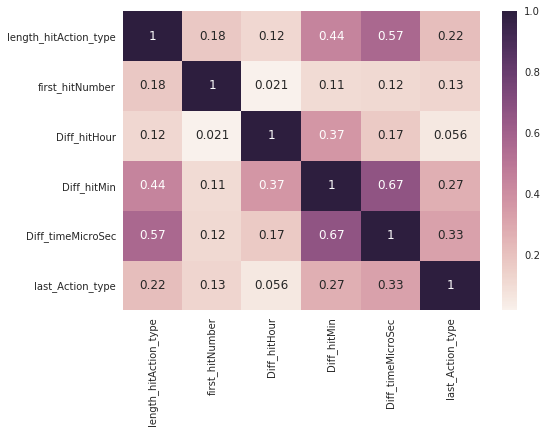

In [68]:
corrMatrix = lengthAction_and_lastAction_pd.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# 3. Data Modeling

In [69]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder,\
VectorIndexer, QuantileDiscretizer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.clustering import *
from pyspark.ml.feature import Bucketizer

In [70]:
def get_evaluation(trainingSet,testingSet,algo,\
                   categoricalCols,continuousCols,discretedCols,split_range,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col
    
    
    labelIndexer = StringIndexer(inputCol=labelCol,\
                             outputCol='indexedLabel',\
                             handleInvalid='keep')

    indexers = [ StringIndexer(handleInvalid='keep',\
                               inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]
    discretizers = [ Bucketizer(inputCol=d, outputCol="{0}_discretized".format(d)\
                 ,splits=split_range)
                 for d in discretedCols ]
    
    
    featureCols = ['features']
    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols +\
                                [discretizer.getOutputCol() for discretizer in discretizers], \
                                outputCol='features')
    
    
    #var_name = algo
    ml_algorithm = algo(featuresCol='features',\
                                labelCol=labelCol)
    


    pipeline = Pipeline(stages=indexers + encoders + discretizers + \
                        [assembler] + [ml_algorithm])
    
    

    model=pipeline.fit(trainingSet)
    result_df = model.transform(testingSet)
    evaluator_RF = MulticlassClassificationEvaluator(predictionCol="prediction",\
                                              labelCol=labelCol, metricName='accuracy')
    print(algo,'====>',evaluator_RF.evaluate(result_df)*100)

    return model

In [71]:
final_df.printSchema()

root
 |-- fullVisitorId: string (nullable = true)
 |-- visitId: string (nullable = true)
 |-- first_hitNumber: integer (nullable = true)
 |-- last_hitNumber: integer (nullable = true)
 |-- Diff_hitNumber: integer (nullable = true)
 |-- Diff_hitHour: integer (nullable = true)
 |-- Diff_hitMin: integer (nullable = true)
 |-- Diff_timeMicroSec: integer (nullable = true)
 |-- first_Action_type: string (nullable = true)
 |-- last_Action_type: float (nullable = true)
 |-- collect_list(hitAction_type): array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- seq_hitAction_type: string (nullable = true)
 |-- length_hitAction_type: integer (nullable = true)



In [72]:
catcols = [\
###'first_Action_type',
           'seq_hitAction_type'
          ]

num_cols = [\
###'first_hitNumber',
 #'last_hitNumber',
 #'Diff_hitNumber',
 #'Diff_hitHour',
 #'Diff_hitMin',
 'Diff_timeMicroSec',
            'length_hitAction_type'
           ]

discols = [\
           #'pub_rec',\
           #'seq_hitAction_type'\
          ]



labelCol = 'last_Action_type'

splits = [-1.0, 0.0, 10.0, 20.0, 30.0, 40.0, float("inf")]

#selected_algo = [DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LogisticRegression]
selected_algo = [LogisticRegression]

In [73]:
training_df, testing_df = final_df.randomSplit(weights = [0.80, 0.20], seed = 13)

In [74]:
for a in selected_algo:
    model = get_evaluation(training_df,testing_df,a,catcols,num_cols,discols, splits, labelCol)

<class 'pyspark.ml.classification.LogisticRegression'> ====> 89.48542692212345


In [75]:
training_df.count()

225515

In [76]:
testing_df.count()

56474

In [77]:
testing_df

DataFrame[fullVisitorId: string, visitId: string, first_hitNumber: int, last_hitNumber: int, Diff_hitNumber: int, Diff_hitHour: int, Diff_hitMin: int, Diff_timeMicroSec: int, first_Action_type: string, last_Action_type: float, collect_list(hitAction_type): array<string>, seq_hitAction_type: string, length_hitAction_type: int]

In [78]:
testing_df.groupBy('last_Action_type').count().orderBy('last_Action_type').show()

+----------------+-----+
|last_Action_type|count|
+----------------+-----+
|             0.0|48296|
|             1.0|  855|
|             2.0| 2932|
|             3.0| 1726|
|             4.0|  328|
|             5.0| 1005|
|             6.0| 1332|
+----------------+-----+



In [79]:
model.transform(testing_df).filter(col(labelCol) == col('prediction'))\
.groupBy(labelCol,'prediction').count().orderBy(labelCol).show()

+----------------+----------+-----+
|last_Action_type|prediction|count|
+----------------+----------+-----+
|             0.0|       0.0|47085|
|             1.0|       1.0|   25|
|             2.0|       2.0|   43|
|             3.0|       3.0| 1278|
|             4.0|       4.0|    1|
|             5.0|       5.0|  786|
|             6.0|       6.0| 1318|
+----------------+----------+-----+



In [80]:
model.transform(testing_df).filter(col(labelCol) != col('prediction'))\
.groupBy(labelCol,'prediction').count().orderBy(labelCol).show(100)

+----------------+----------+-----+
|last_Action_type|prediction|count|
+----------------+----------+-----+
|             0.0|       2.0|    2|
|             0.0|       4.0|    1|
|             0.0|       3.0|  835|
|             0.0|       5.0|  254|
|             0.0|       6.0|  119|
|             1.0|       5.0|    8|
|             1.0|       0.0|  792|
|             1.0|       3.0|   23|
|             1.0|       6.0|    4|
|             1.0|       2.0|    3|
|             2.0|       1.0|   12|
|             2.0|       0.0| 2794|
|             2.0|       6.0|    9|
|             2.0|       3.0|   51|
|             2.0|       5.0|   23|
|             3.0|       6.0|    5|
|             3.0|       0.0|  383|
|             3.0|       4.0|    1|
|             3.0|       5.0|   57|
|             3.0|       2.0|    2|
|             4.0|       6.0|   59|
|             4.0|       0.0|   45|
|             4.0|       3.0|   26|
|             4.0|       5.0|  197|
|             5.0|       6.0

# TRUE = 6, FALSE = 0

testing.select(['las_'])

! ls -l latestmodel

model.write().overwrite().save('./modelwith2Feature')

model.transform(testing_df).take(3)